ディープニューラルネットワークのフルスクラッチ

深いモデルを設計するにあたってクラス化して、わずかな書き換えで様々なモデルを設計できるようにしましょう。

このノートブックに好きなように編集して実装を目指してください。

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

# 【問題1】全結合層のクラス化

全結合層をクラス化することで設計を簡単に変えられるようになります。

理想的な形としては、Kerasのように、層を追加していくような実装方法ですが、その前にまず、Diverのテキストに沿った形で実装しましょう。
そこから先、興味があれば拡張していく形で実装してみてください。

以上に示したようなクラスを作成するために、全結合層をクラス化させていきましょう。

In [2]:
#Full Connected Layer Class
class FC:
    """
    層の生成
    
    Parameters
    ----------
    combination : object instance
      結合関数インスタンス
    activation : object instance
      活性化関数インスタンス
    initializer : object instance
      初期化方法のインスタンス
    optimizer : object instance
      最適化手法のインスタンス
    n_nodes_prev : int
      前の層のノード数
    n_nodes_self : int
      自身の層のノード数
      
    Attributes
    ----------
    w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      重みパラメータ
    b : 次の形のndarray, shape (n_nodes_self, )
      バイアスパラメータ
    input : 次の形のndarray, shape (batch_size, n_nodes_prev)
      入力データ
    output : 次の形のndarray, shape (batch_size, n_nodes_self)
      出力データ
    prev : object instance
      前の層
    next : object instance
      後の層
    """
    def __init__(self, combination, activation, initializer, optimizer, n_nodes_prev, n_nodes_self):
        self.comb = combination
        self.activ = activation
        self.initializer = initializer # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.optimizer = optimizer
        self.n_nodes_prev = n_nodes_prev
        self.n_nodes_self = n_nodes_self
        
        self.w = self.initializer.W(self.n_nodes_prev, self.n_nodes_self)
        self.b = self.initializer.B(self.n_nodes_self)
        self.input = None
        self.output = None
        self.prev = None
        self.next = None
    
    def forward(self, X):
        """
        順伝播
        
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes_prev)
            入力
            
        Returns
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_self)
            出力
        """        
        A = self.comb.forward(X, self.w, self.b)
        Z = self.activ.forward(A)
        
        self.input = X
        self.output = Z
        
        if self.next:
            return self.next.forward(Z)
        else:
            return Z
    
    def backward(self, y, lr):
        """
        逆伝播
        
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes_self)
            後ろから流れてきた勾配
        lr : float
          学習率
        """
        dA = self.activ.backward(y)
        dz, dw, db = self.comb.backward(self.input, self.w, dA)

        # パラメータ更新
        self.w -= lr * self.optimizer.update_dw(self, dw)
        self.b -= lr * self.optimizer.update_db(self, db)
        
        if self.prev:
            self.prev.backward(dz, lr)
        else:
            pass
        
        
def _connect_layers(self, layers):
    """
    全層の結合

    Parameters
    ----------
    layers : list
      ネットワークに組み込まれる層のリスト
    """
    for i, layer in enumerate(layers): 

        if i == 0:
            layer.next = self.layers[i+1]

        elif layer == self.layers[-1]:
            layer.prev = self.layers[i-1]

        else:
            layer.next = self.layers[i+1]
            layer.prev = self.layers[i-1]

# 【問題2】初期化方法のクラス化

In [3]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes_prev, n_nodes_self):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes_prev : int
          前の層のノード数
        n_nodes_self : int
          自身の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
        """
        W = self.sigma * np.random.randn(n_nodes_prev, n_nodes_self)
        return W
    
    def B(self, n_nodes_self):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes_self : int
          自身の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes_self, )
        """
        B = np.random.randn(n_nodes_self)
        return B

# 【問題３】最適化方法のクラス化
全結合層にあるbackwardのself.optimizer.update(self)で学習できるようにしましょう。

In [4]:
class SGD:
    """
    確率的勾配降下法
    """
    def __init__(self):
        pass
        
    def update_dw(self, layer, grad):
        """
        ある層の重み勾配を渡す
        
        Parameters
        ----------
        layer : instance object
          更新前の層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          重みの勾配
        """
        return grad
    
    def update_db(self, layer, grad):
        """
        ある層のバイアス勾配を渡す
        
        Parameters
        ----------
        layer : instance object
          更新前の層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_self, )
          バイアスの勾配
        """
        return grad

# 【問題4】活性化関数のクラス化

In [5]:
class Linear:
    """
    線形結合
    
    Parameters
    ----------
    A_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dZ_ : 次の形のndarray, shape (batch_size, n_nodes_prev)
      逆伝播入力に対するdZ勾配
    dw_ : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      逆伝播入力に対するdw勾配
    db_ : 次の形のndarray, shape (n_nodes_self, )
      逆伝播入力に対するdb勾配
    """
    def __init__(self):
        self.A_ = None
        self.dZ_ = None
        self.dw_ = None
        self.db_ = None
        
    def forward(self, Z, w, b):
        """
        順伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        b : 次の形のndarray, shape (n_nodes_self, )
          ある層のバイアス
        """
        self.A_ = Z @ w + b
        
        return self.A_
    
    def backward(self, Z, w, dA):
        """
        逆伝播
        
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes_prev)
          ある層に順伝播された特徴量データ
        w : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          ある層の重み
        dA : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたAに関するLoss勾配
        """
        self.dZ_ = dA @ w.T
        self.dw_ = Z.T @ dA
        self.db_ = np.sum(dA, axis=0)
        
        return self.dZ_, self.dw_, self.db_

In [6]:
class Sigmoid:
    """
    シグモイド関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = 1 / (1+np.exp(-A))
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * ((1 - self.Z_) * self.Z_)
    
        return self.dA_

In [7]:
class Tanh:
    """
    ハイパーボリックタンジェント関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = np.tanh(A)
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * (1 - self.Z_**2)
        
        return self.dA_

In [8]:
class Softmax:
    """
    SoftMax関数
    
    Parameters
    ----------
    Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      順伝播の出力
    dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
      逆伝播入力に対するdA勾配
    """
    def __init__(self):
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        # オーバーフロー対策として定数を引き算する
        C = np.max(A)
        self.Z_ = np.exp(A - C) / np.sum(np.exp(A - C), axis=1)[:, None]
        
        return self.Z_
    
    def backward(self, y):
        """
        逆伝播
        
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes_self)
          正解ラベルデータ
        """
        self.dA_ = self.Z_ - y
        
        return self.dA_

# 【問題5】ReLUクラスの作成
発展的な活性化関数を作成しましょう。ReLUという活性化関数によって、勾配消失の問題が解消され、層のディープ化が可能になりました。

\begin{align}
    f(x) = ReLU(x) = 
    \begin{cases}
        x　　(x>0)  \\
        0　　(x\leq0)
    \end{cases}  \\
    \frac{\partial f(x)}{\partial x} =
    \begin{cases}
        1　　(x>0) \\
        0　　(x\leq0)
    \end{cases}
\end{align}
本来、解析的には$x=0$で微分不可ですが、$f'(x=0)=0$とすることで対応しています。

In [9]:
class ReLu:
    def __init__(self):
        """
        ReLu関数

        Parameters
        ----------
        Z_ : 次の形のndarray, shape (batch_size, n_nodes_self)
          順伝播の出力
        dA_ : 次の形のndarray, shape (batch_size, n_nodes_self)
          逆伝播入力に対するdA勾配
        """
        self.Z_ = None
        self.dA_ = None
        
    def forward(self, A):
        """
        順伝播
        
        Parameters
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に順伝播された特徴量データ
        """
        self.Z_ = np.maximum(A, 0)
        
        return self.Z_
    
    def backward(self, dZ):
        """
        逆伝播
        
        Parameters
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes_self)
          ある層に逆伝播されたZに関するLoss勾配
        """
        self.dA_ = dZ * np.where(self.Z_ > 0, 1, 0)
        
        return self.dA_

# 【問題6】重みの初期値

In [10]:
class XavierInitializer:
    """
    ザビエルの初期値によるシンプルな初期化
    
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, n_nodes_prev):
        self.sigma = 1 / np.sqrt(n_nodes_prev)
    
    def W(self, n_nodes_prev, n_nodes_self):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes_prev : int
          前の層のノード数
        n_nodes_self : int
          自身の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
        """
        W = self.sigma * np.random.randn(n_nodes_prev, n_nodes_self)
        return W
    
    def B(self, n_nodes_self):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes_self : int
          自身の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes_self, )
        """
        B = np.random.randn(n_nodes_self)
        return B
    

In [11]:
class HeInitializer:
    """
    フーの初期値によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, n_nodes_prev):
        self.sigma = np.sqrt(2/n_nodes_prev)
        
    def W(self, n_nodes_prev, n_nodes_self):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes_prev : int
          前の層のノード数
        n_nodes_self : int
          自身の層のノード数

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
        """
        W = self.sigma * np.random.randn(n_nodes_prev, n_nodes_self)
        return W
    
    def B(self, n_nodes_self):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes_self : int
          自身の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes_self, )
        """
        B = np.random.randn(n_nodes_self)
        return B

# 【問題7】最適化手法
最適化手法には様々なものがあります。発展的なものの中でも比較的実装が簡単なAdaGradを実装してみましょう。

In [12]:

class AdaGrad:
    """
    AdaGradによる確率的勾配降下法
    
    Parameters
    ----------
    Hw : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
      ある層のイテレーション毎の重み勾配の二乗和
    Hb : 次の形のndarray, shape (n_nodes_self, )
      ある層のイテレーション毎のバイアス勾配の二乗和
    """
    def __init__(self):
        self.Hw = 1e-8
        self.Hb = 1e-8
        
    def update_dw(self, layer, grad):
        """
        ある層の重み勾配を渡す
        
        Parameters
        ----------
        layer : instance object
          更新前の層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_prev, n_nodes_self)
          重みの勾配
        """
        self.Hw += grad**2
        grad *= (1/np.sqrt(self.Hw))
        
        return grad
    
    def update_db(self, layer, grad):
        """
        ある層のバイアス勾配を渡す
        
        Parameters
        ----------
        layer : instance object
          更新前の層のインスタンス
        grad : 次の形のndarray, shape (n_nodes_self, )
          バイアスの勾配
        """
        self.Hb += grad**2
        grad *= (1/np.sqrt(self.Hb))
        
        return grad

# 【問題8】クラスの完成
モデル全体を設計するクラスを完成させてください。

In [13]:
class ScratchDeepNeuralNetworkClassifier:
    """
    可変層ニューラルネットワーク分類器

    Parameters
    ----------
    layers : list
      ネットワークに組み込まれる層のリスト
    epoch : int
      エポック数
    sigma : float
      初期パラメータ用（SimpleInitializerのみ適用）
    batch_size : int
      ミニバッチのサンプル数
    verbose : bool
      学習経過の出力

    Attributes
    ----------
    loss_train : list
      訓練データに対するLoss
    loss_val : list
      検証データに対するLoss
    """
    def __init__(self, layers, epoch=100, sigma=0.1, lr=0.01, batch_size=100, verbose=False, **kwargs):
        self.layers = layers
        self.epoch = epoch
        self.lr = lr
        self.sigma = sigma
        self.verbose = verbose
        self.batch_size = batch_size
        self.loss_train = []
        self.loss_val = []

    def _connect_layers(self, layers):
        """
        全層の結合
        
        Parameters
        ----------
        layers : list
          ネットワークに組み込まれる層のリスト
        """
        for i, layer in enumerate(layers): 
            
            if i == 0:
                layer.next = self.layers[i+1]
                
            elif layer == self.layers[-1]:
                layer.prev = self.layers[i-1]
                
            else:
                layer.next = self.layers[i+1]
                layer.prev = self.layers[i-1]
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, n_classes)
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, n_classes)
            検証データの正解値
        """
        # レイヤーインスタンスを作成
        self._connect_layers(self.layers)    
        
        for i in range(self.epoch):
            
            get_mini_batch_t = GetMiniBatch(X, y, batch_size=self.batch_size, seed=i)
            
            times = []
            start = time.time()
            
            # 各mini batchの損失をリスト化
            loss_batch_t = []
            
            for X_mini, y_mini in get_mini_batch_t:

                # 順伝播
                output = self.layers[0].forward(X_mini)
                # 逆伝播
                self.layers[-1].backward(y_mini, self.lr)

                loss_batch_t.append(self.cross_entropy(output, y_mini))
            
            # 各epochの平均損失をselfに格納
            loss_train = np.mean(loss_batch_t)
            self.loss_train.append(loss_train)
            
            
            # 検証データの推定
            if hasattr(X_val, '__array__') and hasattr(y_val, '__array__'):
                
                batch_size_v = int(self.batch_size * len(X_val)/len(X))
                get_mini_batch_v = GetMiniBatch(X_val, y_val, batch_size=batch_size_v)
                loss_batch_v = []

                for X_mini, y_mini in get_mini_batch_v:
                    
                    output = self.layers[0].forward(X_mini)
                
                    loss_batch_v.append(self.cross_entropy(output, y_mini))
            
                # 各epochの平均損失をselfに格納
                loss_val = np.mean(loss_batch_v)
                self.loss_val.append(loss_val)

            end = time.time()
            times.append(end-start)

            # 学習経過の出力
            if self.verbose and (i+1) % 10 == 0:
                print("Epoch {}; Loss {:.4f}".format(i+1, loss_train),
                      "  --Avg Epoch Time {:.4f}sec".format(np.mean(times)))            
                   
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          検証用データ

        Returns
        -------
          次の形のndarray, shape (n_samples, )
          推定結果
        """
        output = self.layers[0].forward(X)
        
        return np.argmax(output, axis=1)
        
    def cross_entropy(self, X, y):
        """
        クロスエントロピー誤差を計算

        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_features)
          入力データ
        y : 次の形のndarray, shape (batch_size, n_classes)
          入力データの正解ラベル

        Returns
        -------
          float
          クロスエントロピー誤差
        """
        return (-1/len(X)) * np.sum((y*np.log(X)))

# 【問題9】学習と推定
ノード数や層の数、活性化関数を変えたネットワークを作成して、それぞれの結果を比較してみてください。

In [14]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [15]:
#《データセットをダウンロードするコード》
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

/usr/local/var/pyenv/versions/3.7.8/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


1.0
0.0


In [16]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

print(y_train_one_hot.shape) # (60000, 10)

(60000, 10)


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [18]:
import matplotlib.pyplot as plt

def plot_loss(model, title='Scratch DNN Loss'):
    plt.figure()

    plt.plot(np.arange(len(model.loss_train)), model.loss_train, label='train loss')
    plt.plot(np.arange(len(model.loss_val)), model.loss_val, label='val loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

## 4層のSigmoidネットワーク（SGD最適化）

Epoch 10; Loss 0.0948   --Avg Epoch Time 2.2742sec
Epoch 20; Loss 0.0290   --Avg Epoch Time 2.3676sec
Epoch 30; Loss 0.0066   --Avg Epoch Time 2.2954sec
Epoch 40; Loss 0.0021   --Avg Epoch Time 2.2524sec
Epoch 50; Loss 0.0011   --Avg Epoch Time 2.3303sec
Epoch 60; Loss 0.0007   --Avg Epoch Time 2.4979sec
Epoch 70; Loss 0.0005   --Avg Epoch Time 2.4570sec
Epoch 80; Loss 0.0004   --Avg Epoch Time 2.3885sec
Epoch 90; Loss 0.0003   --Avg Epoch Time 2.4147sec
Epoch 100; Loss 0.0002   --Avg Epoch Time 2.4992sec

 Accuracy: 0.98


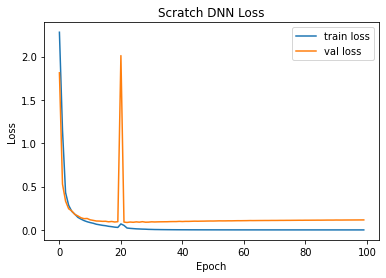

In [19]:
from sklearn.metrics import accuracy_score

layer_1 = FC(Linear(), Sigmoid(), XavierInitializer(784), SGD(), 784, 400)
layer_2 = FC(Linear(), Sigmoid(), XavierInitializer(400), SGD(), 400, 200)
layer_3 = FC(Linear(), Sigmoid(), XavierInitializer(200), SGD(), 200, 100)
output = FC(Linear(), Softmax(), XavierInitializer(100), SGD(), 100, 10)

params = {'epoch': 100, 
          'lr': 0.01,
          'sigma':  0.01,
          'batch_size': 200,
          }

nn_sig4 = ScratchDeepNeuralNetworkClassifier(layers=[layer_1, layer_2, layer_3, output], verbose=True, **params)

nn_sig4.fit(X_train, y_train, X_val, y_val)

pred = nn_sig4.predict(X_test)

print("\n Accuracy: {}".format(accuracy_score(y_test, pred)))

plot_loss(nn_sig4)

## 4層のSigmoidネットワーク（AdaGrad最適化）

Epoch 10; Loss 0.1277   --Avg Epoch Time 2.8917sec
Epoch 20; Loss 0.0785   --Avg Epoch Time 2.9099sec
Epoch 30; Loss 0.0553   --Avg Epoch Time 2.8769sec
Epoch 40; Loss 0.0408   --Avg Epoch Time 2.9657sec
Epoch 50; Loss 0.0309   --Avg Epoch Time 2.8784sec
Epoch 60; Loss 0.0238   --Avg Epoch Time 2.7177sec
Epoch 70; Loss 0.0185   --Avg Epoch Time 2.7136sec
Epoch 80; Loss 0.0146   --Avg Epoch Time 2.8061sec
Epoch 90; Loss 0.0118   --Avg Epoch Time 2.7149sec
Epoch 100; Loss 0.0095   --Avg Epoch Time 2.7173sec

 Accuracy: 0.9784


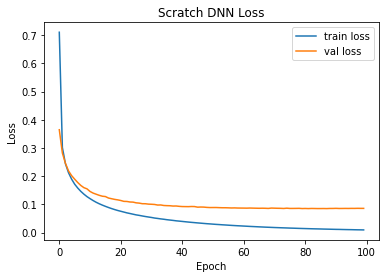

In [20]:
layer_1 = FC(Linear(), Sigmoid(), XavierInitializer(784), AdaGrad(), 784, 400)
layer_2 = FC(Linear(), Sigmoid(), XavierInitializer(400), AdaGrad(), 400, 200)
layer_3 = FC(Linear(), Sigmoid(), XavierInitializer(200), AdaGrad(), 200, 100)
output = FC(Linear(), Softmax(), XavierInitializer(100), AdaGrad(), 100, 10)

params = {'epoch': 100, 
          'lr': 0.01,
          'sigma':  0.01,
          'batch_size': 200,
          }

nn_sig4 = ScratchDeepNeuralNetworkClassifier(layers=[layer_1, layer_2, layer_3, output], verbose=True, **params)

nn_sig4.fit(X_train, y_train, X_val, y_val)

pred = nn_sig4.predict(X_test)

print("\n Accuracy: {}".format(accuracy_score(y_test, pred)))

plot_loss(nn_sig4)

## 4層のReLuネットワーク

Epoch 10; Loss 0.0193   --Avg Epoch Time 2.6112sec
Epoch 20; Loss 0.0044   --Avg Epoch Time 2.7553sec
Epoch 30; Loss 0.0018   --Avg Epoch Time 2.7767sec
Epoch 40; Loss 0.0010   --Avg Epoch Time 2.6408sec
Epoch 50; Loss 0.0007   --Avg Epoch Time 2.6127sec
Epoch 60; Loss 0.0005   --Avg Epoch Time 2.7571sec
Epoch 70; Loss 0.0004   --Avg Epoch Time 2.6889sec
Epoch 80; Loss 0.0003   --Avg Epoch Time 3.1550sec
Epoch 90; Loss 0.0002   --Avg Epoch Time 3.0230sec
Epoch 100; Loss 0.0002   --Avg Epoch Time 3.2776sec

 Accuracy: 0.9799


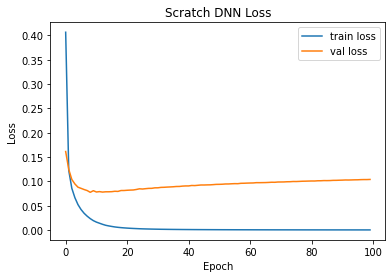

In [21]:
layer_1 = FC(Linear(), ReLu(), HeInitializer(784), AdaGrad(), 784, 400)
layer_2 = FC(Linear(), ReLu(), HeInitializer(400), AdaGrad(), 400, 200)
layer_3 = FC(Linear(), ReLu(), HeInitializer(200), AdaGrad(), 200, 100)
output = FC(Linear(), Softmax(), HeInitializer(100), AdaGrad(), 100, 10)

params = {'epoch': 100, 
          'lr': 0.01,
          'sigma':  0.01,
          'batch_size': 200,
          }

nn_relu4 = ScratchDeepNeuralNetworkClassifier(layers=[layer_1, layer_2, layer_3, output], verbose=True, **params)

nn_relu4.fit(X_train, y_train, X_val, y_val)

pred = nn_relu4.predict(X_test)

print("\n Accuracy: {}".format(accuracy_score(y_test, pred)))

plot_loss(nn_relu4)